In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
logger.remove()

import sys
print(sys.path)

from pim.simulator import SimulationExperiment

['/data/deox/lu/exjobb/path-integration-memory/notebooks/results', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/data/deox/lu/exjobb/path-integration-memory/venv/lib/python3.8/site-packages', '/data/deox/lu/exjobb/path-integration-memory/lib']


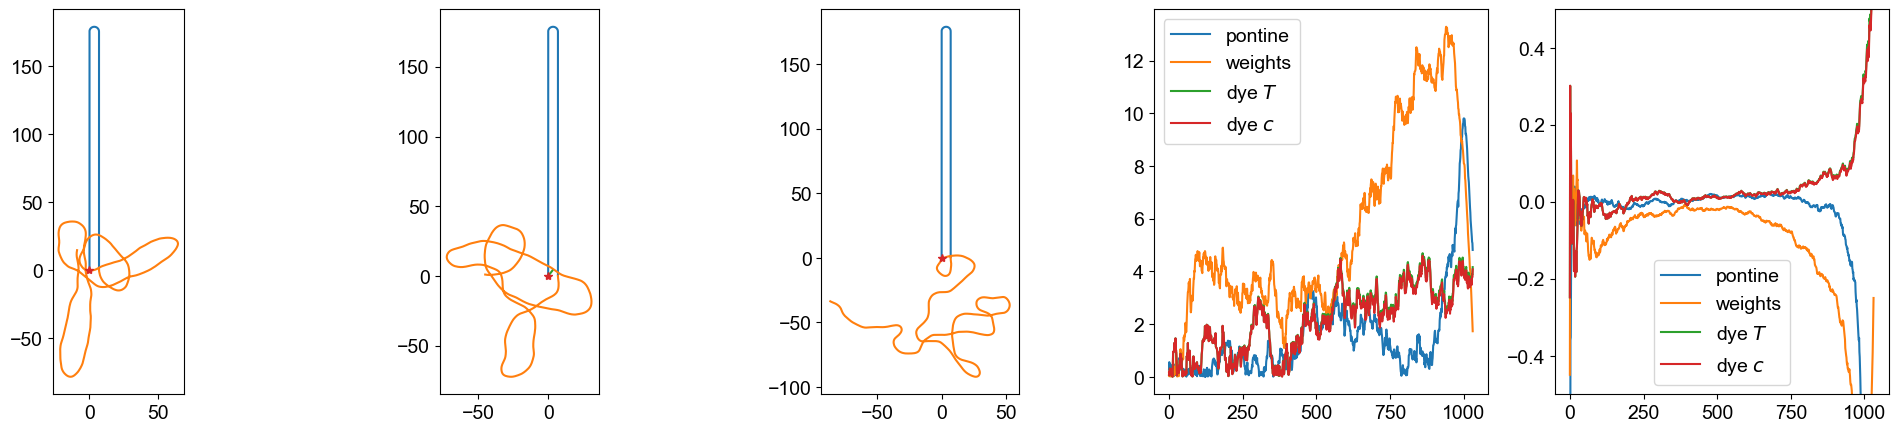

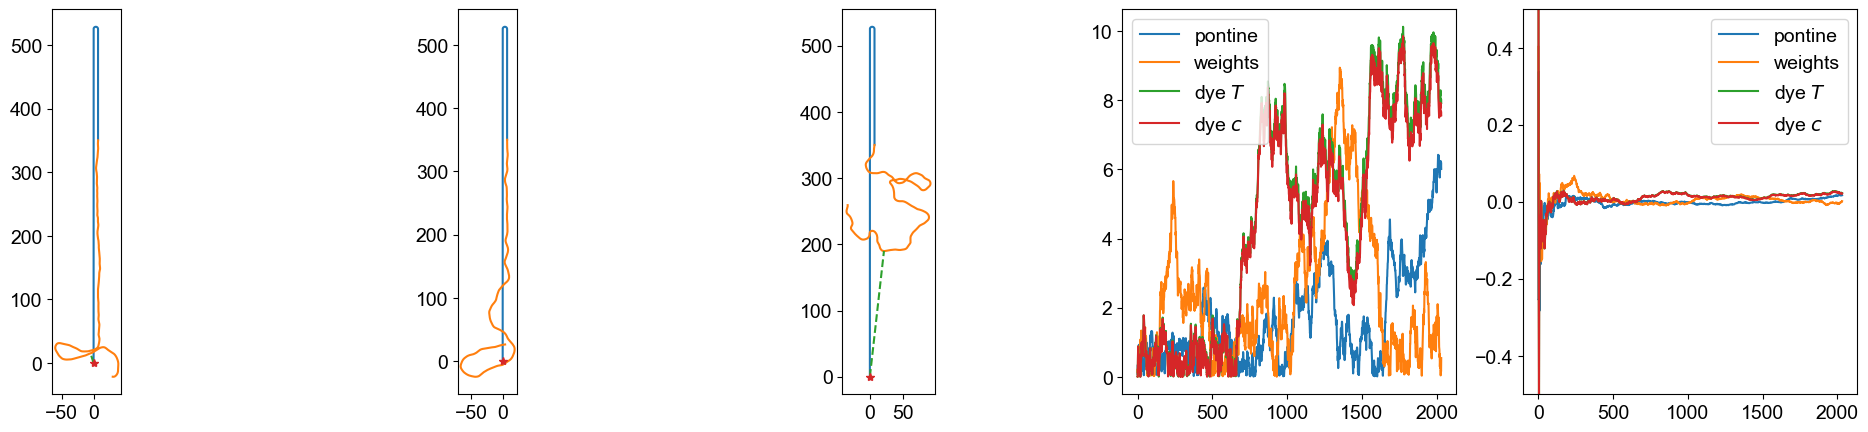

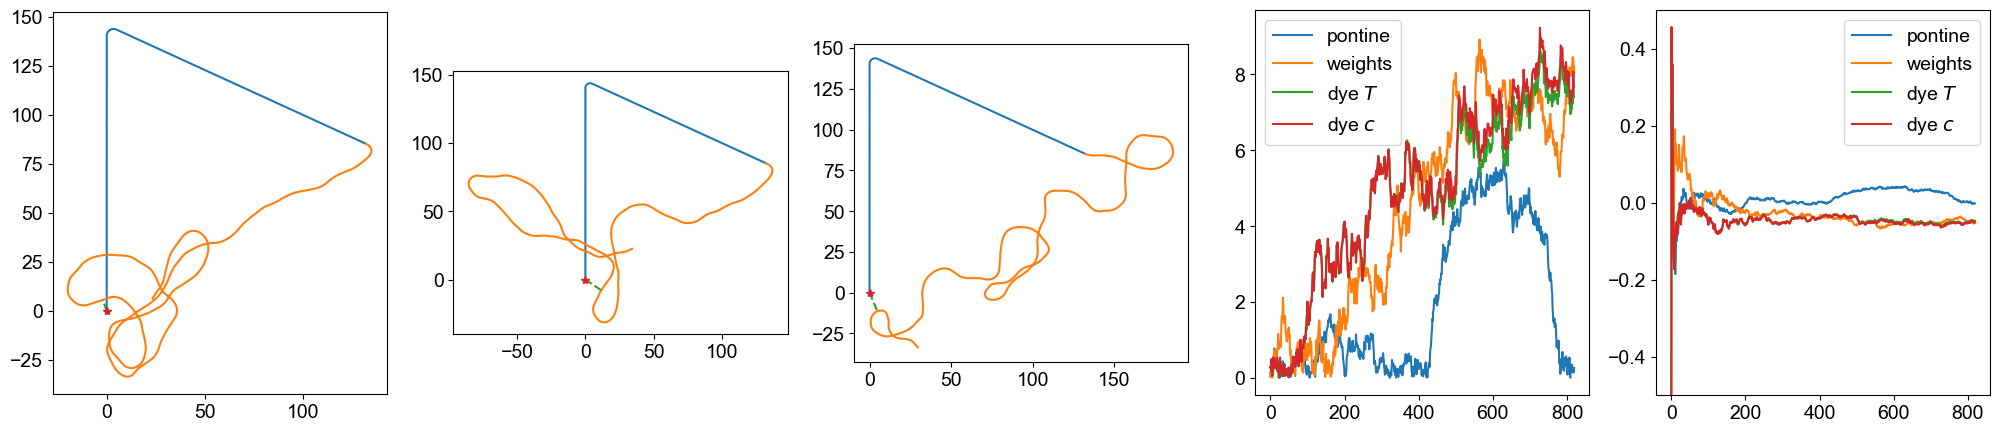

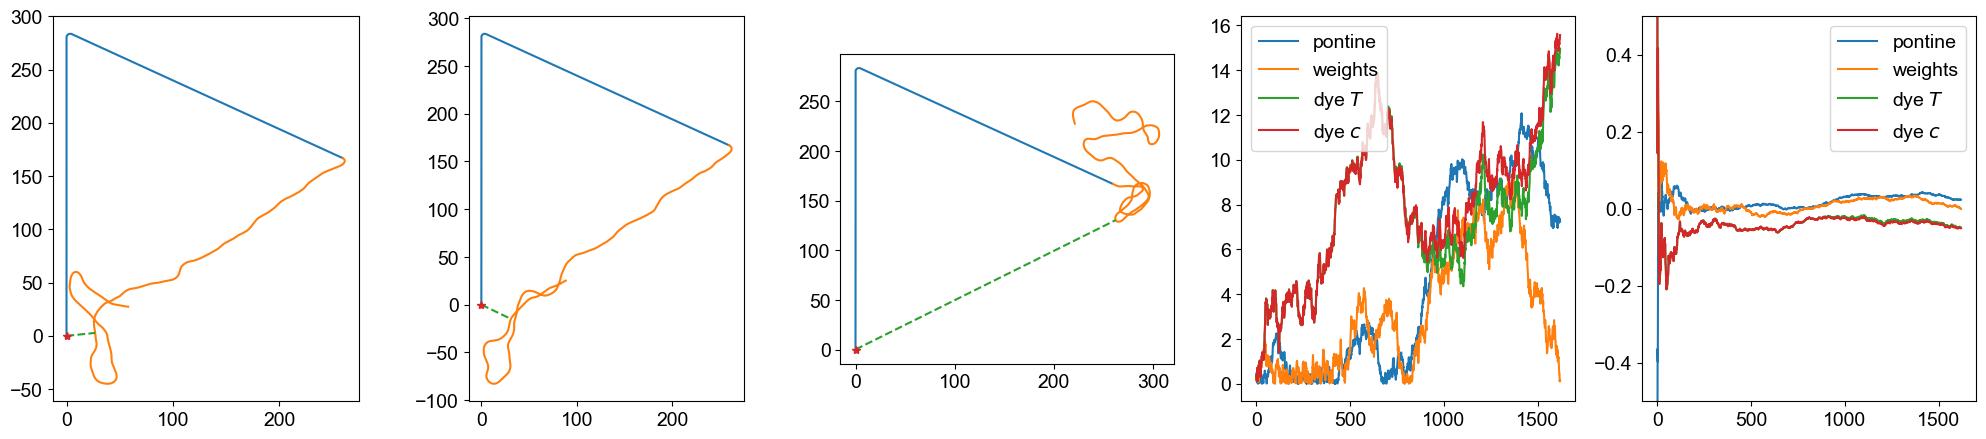

In [58]:
# We want to explore the consequences of non-linear integration on homing performance.
# In particular, there are two properties we want:
# * Movements of the same distance in opposite directions should cancel out, and
# * Movements of the same angular distance should change the phase equally, regardless of distance from home

def turn(f, t, per):
    headings = np.arange(f, t, per)
    return np.vstack([np.ones(len(headings)), headings]).T

# To test the first property, let's just move in one direction and then back:
path1p1 = np.vstack([
    [[500, 0]],
    turn(0, np.pi, 0.1),
    [[500, np.pi]]
])

path2p1 = np.vstack([
    [[1500, 0]],
    turn(0, np.pi, 0.1),
    [[500, np.pi]]
])

path1p2 = np.vstack([
    [[400, 0]],
    turn(0, 2, 0.1),
    [[400, 2]],
])

path2p2 = np.vstack([
    [[800, 0]],
    turn(0, 2, 0.1),
    [[800, 2]],
])

# To test the second property, let's move in one direction for r units, and then turn

cx_pontine = {
    "type": "pontine",
    "params": {
        "noise": 0.1
    }
}

cx_weights = {
    "type": "weights",
    "output_layer": "motor",
    "params": {
        "noise": 0.1,
        "mem_fade": 0.15 + 0.5,
        "mem_gain": 0.0025,
        "beta": 0.5,
    }
}

cx_dye = {
    "type": "dye",
    "output_layer": "motor",
    "params": {
        "cheat": True,
        "noise": 0.10,
        "mem_initial": 0.0,
        "pfn_weight_factor": 1,
        "phi": 0.00045,
        "beta": 0.1,
        "k": 0,
        "epsilon": 1,
        "length": 1,
        "c_tot": 0.3,
        "cheat_slope": 100,
        "start_at_stable": False,
        "disable_beta_on_outbound": False
    }
}

def run_experiment(cx, mf):
    parameters = {
        "type": "simulation",
        #"seed": 42,
        "T_inbound": 1000,
        #"T_outbound": 1500,
        #"min_homing_distance": 300,
        "path": path,
        "motor_factor": mf,
        "record": ["memory"],
        "cx": cx,
    }
    experiment = SimulationExperiment(parameters)
    results = experiment.run("test", "")
    return results


for path in [path1p1, path2p1, path1p2, path2p2]:
    results_pontine = run_experiment(cx_pontine, 1.0)
    results_weights = run_experiment(cx_weights, 0.25)
    results_dye = run_experiment(cx_dye, -0.25)
    T_outbound = results_pontine.T_outbound
    
    fig, (ax1, ax2, ax3, err, err2) = plt.subplots(1, 5, figsize=(25, 5))
    ax1.set_aspect(1)
    ax2.set_aspect(1)
    ax3.set_aspect(1)
    results_pontine.plot_path(ax1, search_pattern=False)
    results_weights.plot_path(ax2, search_pattern=False)
    results_dye.plot_path(ax3, search_pattern=False)
    
    err.plot(results_pontine.memory_error()[:T_outbound], label="pontine")
    err.plot(results_weights.memory_error()[:T_outbound], label="weights")
    results_dye.internal_memory_index = 1
    err.plot(results_dye.memory_error()[:T_outbound], label="dye $T$")
    results_dye.internal_memory_index = 0
    err.plot(results_dye.memory_error()[:T_outbound], label="dye $c$")
    err.legend()
    
    err2.plot(results_pontine.angular_memory_error()[:T_outbound], label="pontine")
    err2.plot(results_weights.angular_memory_error()[:T_outbound], label="weights")
    results_dye.internal_memory_index = 1
    err2.plot(results_dye.angular_memory_error()[:T_outbound], label="dye $T$")
    results_dye.internal_memory_index = 0
    err2.plot(results_dye.angular_memory_error()[:T_outbound], label="dye $c$")
    err2.set_ylim(-0.5, 0.5)
    err2.legend()